In [2]:
import torch 
from torch.utils.data import DataLoader 
from tqdm import tqdm 
import numpy as np
from typing import List, Optional, Tuple
import sys 
sys.path.insert(0, "../")
from DEFAULTS import BASE_PATH 
from model_builder import get_pretrained_model_v2 

MODEL = "mae-lightning-small"
WEIGHTS = "MAE_SMALL_STED"
GLOBAL_POOL = "avg"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, cfg = get_pretrained_model_v2(
    name=MODEL,
    weights=WEIGHTS,
    path=None,
    mask_ratio=0.0,
    pretrained=True if "imagenet" in WEIGHTS.lower() else False,
    in_channels=3 if "imagenet" in WEIGHTS.lower() else 1,
    as_classifier=True,
    blocks="all",
    num_classes=4
)
model.to(DEVICE)
model.eval()

mask_ratio 0.0
pretrained False
in_channels 1
blocks all
num_classes 4
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


In [3]:
import tarfile 
import io


train_embeddings, train_names = [], [] 
with tarfile.open("/home-local/Frederic/Datasets/ALS/catalog/train_ALS.tar", "r") as handle:
    members = handle.getmembers()
    for m in tqdm(members, total=len(members)):
        buffer = io.BytesIO()
        buffer.write(handle.extractfile(m).read())
        buffer.seek(0)
        data = np.load(buffer, allow_pickle=True)
        data = {key: values for key, values in data.items()}
        img = data["img"]
        metadata = data["metadata"]
        img = torch.tensor(img[np.newaxis, ...], dtype=torch.float32).unsqueeze(0).to(DEVICE)
        output = model.forward_features(img)
        name = m.name 
        train_embeddings.extend(output.data.cpu().numpy())
        train_names.append(name)

train_embeddings = np.array(train_embeddings)
print(train_embeddings.shape)
print(len(train_names))

100%|██████████| 12227/12227 [01:07<00:00, 181.01it/s]

(12227, 384)
12227


In [4]:
test_embeddings, test_names = [], [] 
with tarfile.open("/home-local/Frederic/Datasets/ALS/catalog/test_ALS.tar", "r") as handle:
    members = handle.getmembers()
    for m in tqdm(members, total=len(members)):
        buffer = io.BytesIO()
        buffer.write(handle.extractfile(m).read())
        buffer.seek(0)
        data = np.load(buffer, allow_pickle=True)
        data = {key: values for key, values in data.items()}
        img = data["img"]
        metadata = data["metadata"]
        img = torch.tensor(img[np.newaxis, ...], dtype=torch.float32).unsqueeze(0).to(DEVICE)
        output = model.forward_features(img)
        name = m.name 
        test_embeddings.extend(output.data.cpu().numpy())
        test_names.append(name)

test_embeddings = np.array(test_embeddings)
print(test_embeddings.shape)
print(len(test_names))

100%|██████████| 13022/13022 [01:11<00:00, 182.35it/s]

(13022, 384)
13022


# Hierarchical Clustering

### PLKO

(12227, 384)


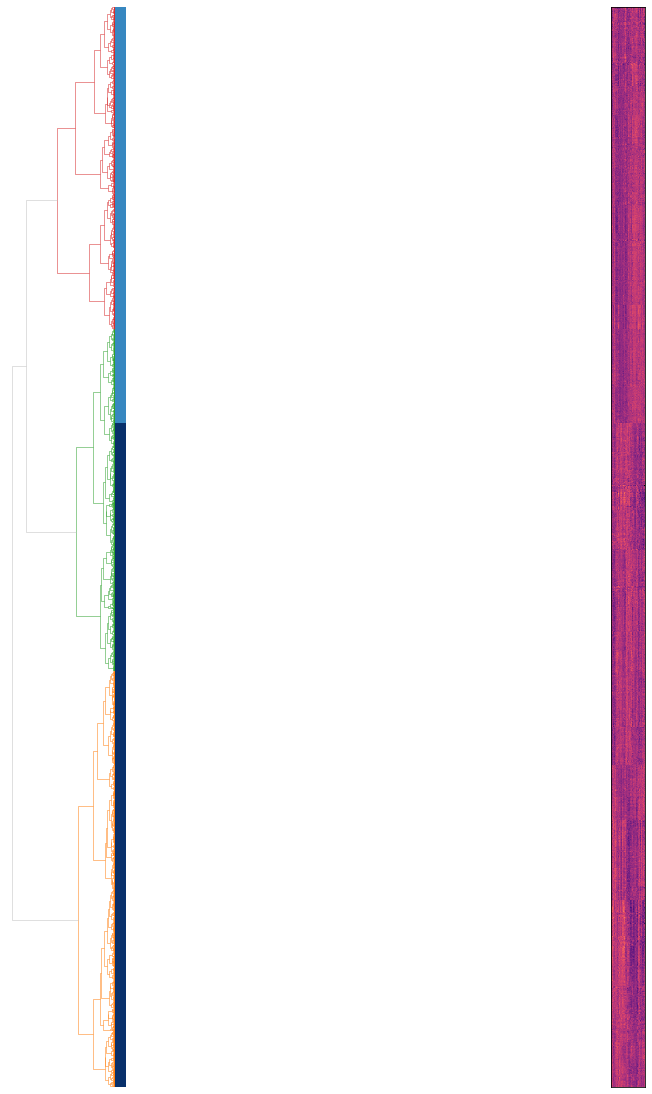

In [25]:
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib

# if labels.dtype == np.float32:
#     labels = labels.astype(np.int32)
# uniques = np.unique(labels)
D = train_embeddings 
print(D.shape)
D = StandardScaler().fit_transform(D) 
Y1 = hierarchy.linkage(D, method="ward", metric="euclidean")
clusters1 = hierarchy.fcluster(Y1, 3, criterion="maxclust")

# Find the distance threshold that gives the same clustering
distances = Y1[:, 2]  # The third column of the linkage matrix contains the distances
threshold = sorted(distances)[1-3]  # n_samples - n_clusters = -3 for 4 clusters d
Y2 = hierarchy.linkage(D.T, method="ward", metric="euclidean")

fig = plt.figure(figsize=(15, 15))
ax3 = fig.add_axes([0, 0, 0.1, 1.0])
ax3.set_xticks([])
ax3.set_yticks([])
fig.gca().invert_yaxis() 
ax3.axis("off")

# zmap = plt.get_cmap("tab10", len(uniques))

Z1 = hierarchy.dendrogram(
    Y1, orientation="left",
    above_threshold_color="silver",
    ax=ax3,
    color_threshold=threshold
)
Z2 = hierarchy.dendrogram(
    Y2, orientation="right",
    above_threshold_color="silver",
    no_plot=True
)
for collection in ax3.collections:
    collection.set_linewidth(0.5)

ax4 = fig.add_axes([0.1,0,0.01,1.0])
ax4.set_xticks([])
ax4.set_yticks([])
ax4.axis('off')

cmap = plt.get_cmap("Blues", 3 + 1)
all_colors = []
for i, leaf in enumerate(Z1["leaves"]):
    ax4.barh(i + 0.5, 1, 1.0, color=cmap(clusters1[leaf] + 1))
#     # ax4.axhline(i + 0.5, color=cmap(GROUPS_MODEL[groups[leaf]] + 1))
ax4.set(
    ylim=(0, len(Z1["leaves"])), xlim=(0, 1)
)
ax4.invert_yaxis()
    

axmatrix2 = fig.add_axes([0.15,0,0.85, 1.0])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

sorted_co_matrix = D[idx1,:]
sorted_co_matrix = sorted_co_matrix[:, idx2]
im2 = axmatrix2.matshow(sorted_co_matrix, aspect='equal', origin='lower', cmap="magma")
axmatrix2.set_xticks([])
axmatrix2.set_yticks([])
fig.gca().invert_yaxis() # this plus the x-axis invert in the right-flipped dendrogram flips the y-axis

100%|██████████| 12227/12227 [00:12<00:00, 1018.41it/s]
<ipython-input-26-acef12a00982>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels, rotation=25)


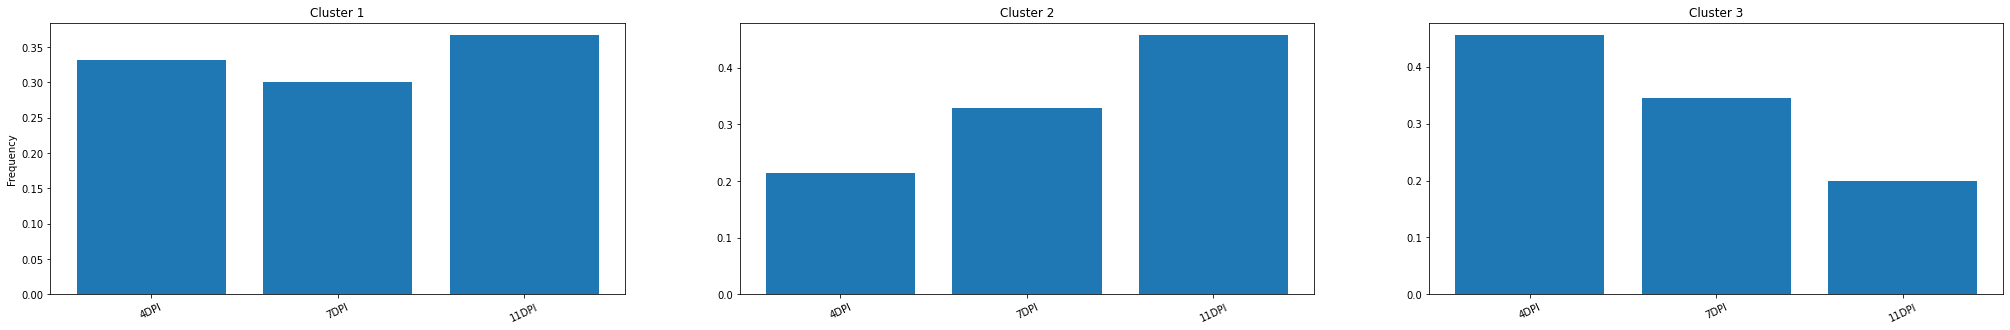

In [26]:
labels = ["4DPI", "7DPI", "11DPI"]
frequencies = {
    key: [0] * len(labels) for key in np.unique(clusters1)
}
all_keys = []
with tarfile.open("/home-local/Frederic/Datasets/ALS/catalog/train_ALS.tar", "r") as handle:
    for cluster_id, member_name in tqdm(zip(clusters1, train_names), total=len(clusters1)):
        member = handle.getmember(name=member_name)
        buffer = io.BytesIO()
        buffer.write(handle.extractfile(member).read())
        buffer.seek(0)
        data = np.load(buffer, allow_pickle=True)
        data = {key: values for key, values in data.items()}
        metadata = data["metadata"].item()
        if metadata["DIV"] == "DIV14":
            continue
        key = metadata["DPI"]
        frequencies[cluster_id][labels.index(key)] += 1

fig, axs = plt.subplots(1, len(np.unique(clusters1)), figsize=(35, 5))
for i in range(len(np.unique(clusters1))):
    total = sum(frequencies[i+1])
    axs[i].bar(labels, [item / total for item in frequencies[i+1]])
    axs[i].set_title(f"Cluster {i+1}")
    axs[i].set_xticklabels(labels, rotation=25)
    axs[0].set_ylabel("Frequency")
plt.show()


100%|██████████| 12227/12227 [00:12<00:00, 1012.51it/s]
<ipython-input-27-a43126ea518b>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels, rotation=25)


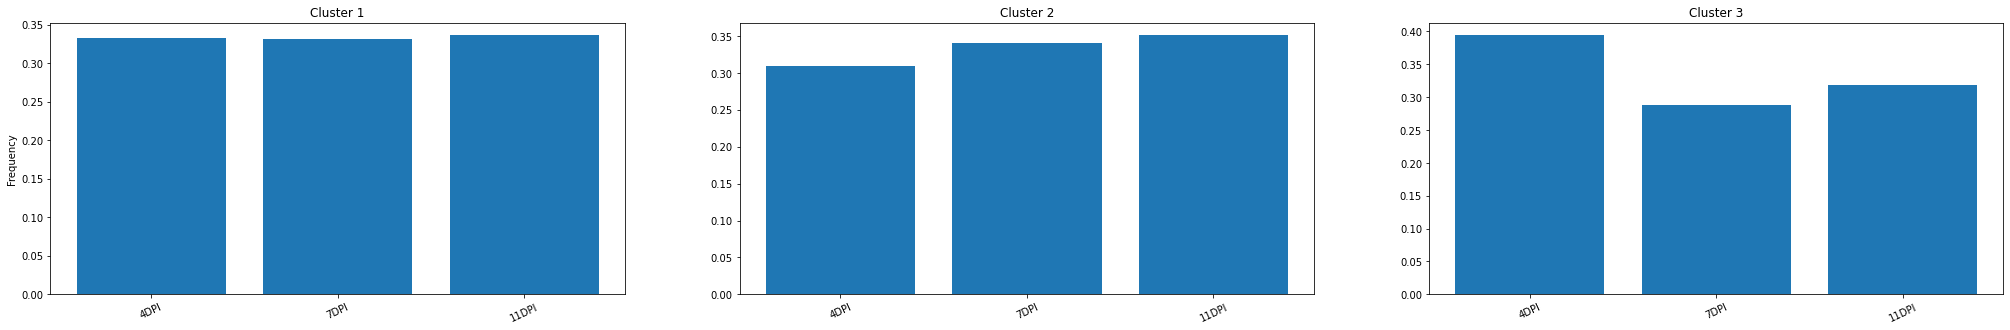

In [27]:
labels = ["4DPI", "7DPI", "11DPI"]
frequencies = {
    key: [0] * len(labels) for key in np.unique(clusters1)
}
all_keys = []
with tarfile.open("/home-local/Frederic/Datasets/ALS/catalog/train_ALS.tar", "r") as handle:
    for cluster_id, member_name in tqdm(zip(clusters1, train_names), total=len(clusters1)):
        member = handle.getmember(name=member_name)
        buffer = io.BytesIO()
        buffer.write(handle.extractfile(member).read())
        buffer.seek(0)
        data = np.load(buffer, allow_pickle=True)
        data = {key: values for key, values in data.items()}
        metadata = data["metadata"].item()
        if metadata["DIV"] == "DIV5":
            continue
        key = metadata["DPI"]
        frequencies[cluster_id][labels.index(key)] += 1

fig, axs = plt.subplots(1, len(np.unique(clusters1)), figsize=(35, 5))
for i in range(len(np.unique(clusters1))):
    total = sum(frequencies[i+1])
    axs[i].bar(labels, [item / total for item in frequencies[i+1]])
    axs[i].set_title(f"Cluster {i+1}")
    axs[i].set_xticklabels(labels, rotation=25)
    axs[0].set_ylabel("Frequency")
plt.show()

### shFUS

(13022, 384)


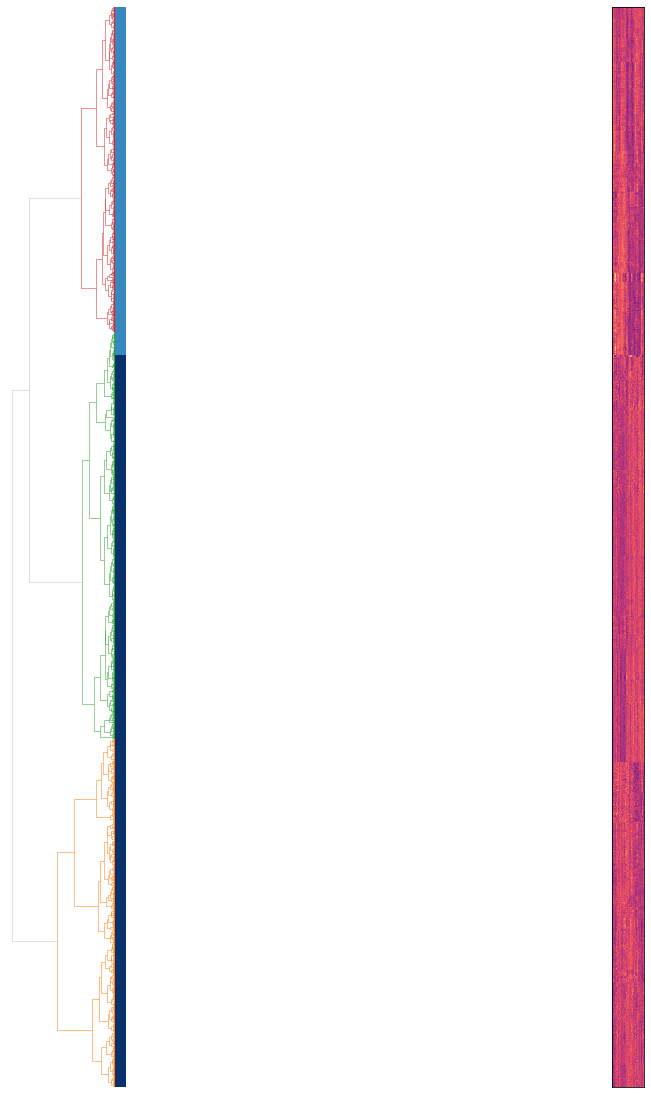

In [28]:
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib

# if labels.dtype == np.float32:
#     labels = labels.astype(np.int32)
# uniques = np.unique(labels)
D = test_embeddings 
print(D.shape)
D = StandardScaler().fit_transform(D) 
Y1 = hierarchy.linkage(D, method="ward", metric="euclidean")
clusters1 = hierarchy.fcluster(Y1, 3, criterion="maxclust")

# Find the distance threshold that gives the same clustering
distances = Y1[:, 2]  # The third column of the linkage matrix contains the distances
threshold = sorted(distances)[1-3]  # n_samples - n_clusters = -3 for 4 clusters d
Y2 = hierarchy.linkage(D.T, method="ward", metric="euclidean")

fig = plt.figure(figsize=(15, 15))
ax3 = fig.add_axes([0, 0, 0.1, 1.0])
ax3.set_xticks([])
ax3.set_yticks([])
fig.gca().invert_yaxis() 
ax3.axis("off")

# zmap = plt.get_cmap("tab10", len(uniques))

Z1 = hierarchy.dendrogram(
    Y1, orientation="left",
    above_threshold_color="silver",
    ax=ax3,
    color_threshold=threshold
)
Z2 = hierarchy.dendrogram(
    Y2, orientation="right",
    above_threshold_color="silver",
    no_plot=True
)
for collection in ax3.collections:
    collection.set_linewidth(0.5)

ax4 = fig.add_axes([0.1,0,0.01,1.0])
ax4.set_xticks([])
ax4.set_yticks([])
ax4.axis('off')

cmap = plt.get_cmap("Blues", 3 + 1)
all_colors = []
for i, leaf in enumerate(Z1["leaves"]):
    ax4.barh(i + 0.5, 1, 1.0, color=cmap(clusters1[leaf] + 1))
#     # ax4.axhline(i + 0.5, color=cmap(GROUPS_MODEL[groups[leaf]] + 1))
ax4.set(
    ylim=(0, len(Z1["leaves"])), xlim=(0, 1)
)
ax4.invert_yaxis()
    

axmatrix2 = fig.add_axes([0.15,0,0.85, 1.0])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

sorted_co_matrix = D[idx1,:]
sorted_co_matrix = sorted_co_matrix[:, idx2]
im2 = axmatrix2.matshow(sorted_co_matrix, aspect='equal', origin='lower', cmap="magma")
axmatrix2.set_xticks([])
axmatrix2.set_yticks([])
fig.gca().invert_yaxis() # this plus the x-axis invert in the right-flipped dendrogram flips the y-axis

100%|██████████| 13022/13022 [00:21<00:00, 617.45it/s] 
<ipython-input-29-9f112dc9ffda>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels, rotation=25)


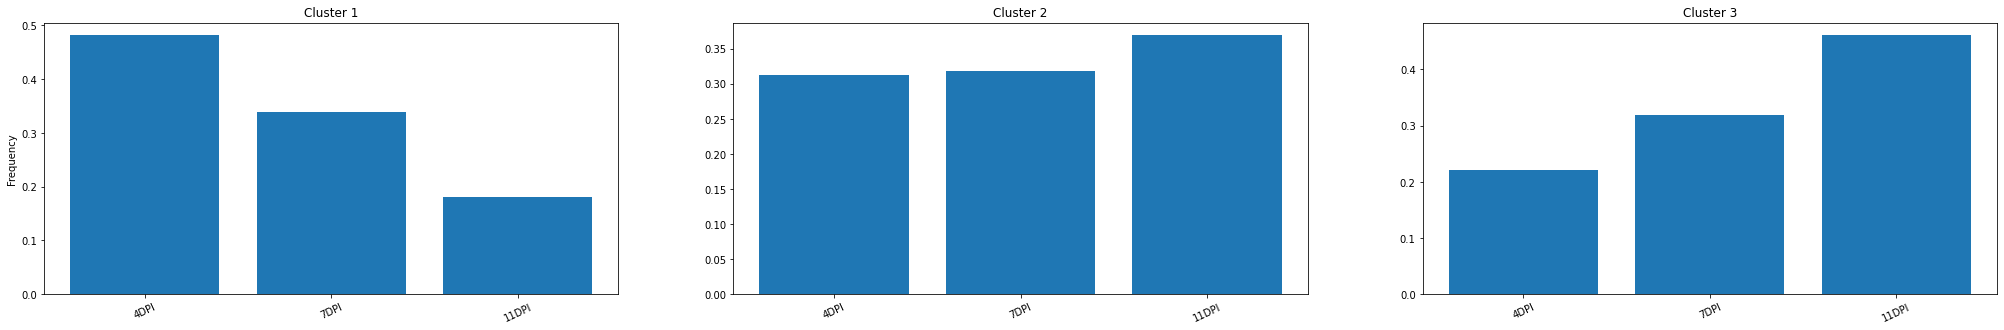

In [29]:
labels = ["4DPI", "7DPI", "11DPI"]
frequencies = {
    key: [0] * len(labels) for key in np.unique(clusters1)
}
all_keys = []
with tarfile.open("/home-local/Frederic/Datasets/ALS/catalog/test_ALS.tar", "r") as handle:
    for cluster_id, member_name in tqdm(zip(clusters1, test_names), total=len(clusters1)):
        member = handle.getmember(name=member_name)
        buffer = io.BytesIO()
        buffer.write(handle.extractfile(member).read())
        buffer.seek(0)
        data = np.load(buffer, allow_pickle=True)
        data = {key: values for key, values in data.items()}
        metadata = data["metadata"].item()
        if metadata["DIV"] == "DIV14":
            continue
        key = metadata["DPI"]
        frequencies[cluster_id][labels.index(key)] += 1

fig, axs = plt.subplots(1, len(np.unique(clusters1)), figsize=(35, 5))
for i in range(len(np.unique(clusters1))):
    total = sum(frequencies[i+1])
    axs[i].bar(labels, [item / total for item in frequencies[i+1]])
    axs[i].set_title(f"Cluster {i+1}")
    axs[i].set_xticklabels(labels, rotation=25)
    axs[0].set_ylabel("Frequency")
plt.show()

100%|██████████| 13022/13022 [00:13<00:00, 985.74it/s] 
<ipython-input-30-afb1a8e725b5>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels, rotation=25)


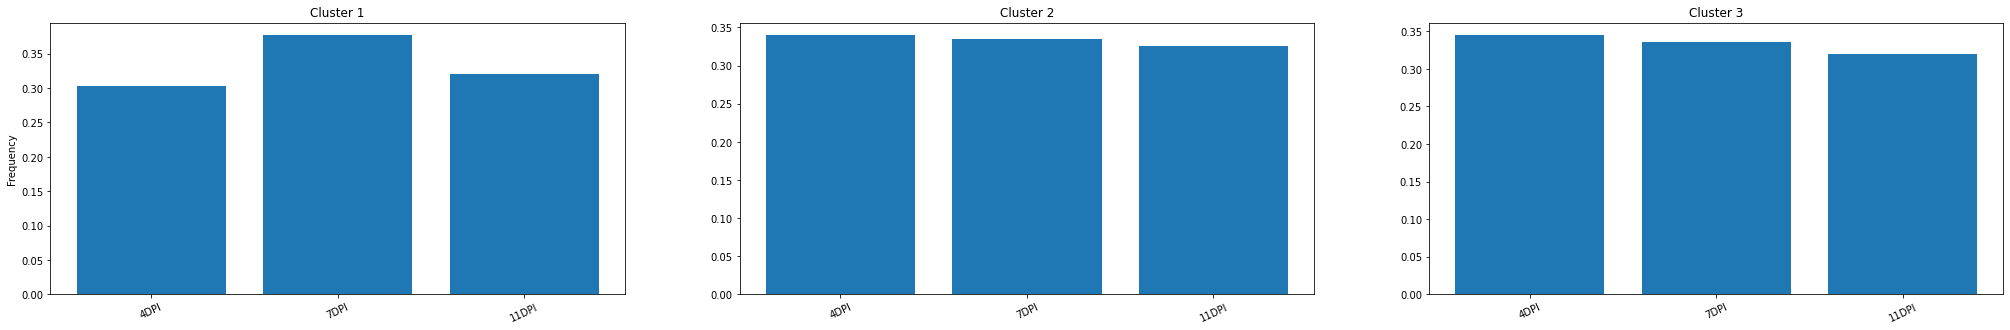

In [30]:
labels = ["4DPI", "7DPI", "11DPI"]
frequencies = {
    key: [0] * len(labels) for key in np.unique(clusters1)
}
with tarfile.open("/home-local/Frederic/Datasets/ALS/catalog/test_ALS.tar", "r") as handle:
    for cluster_id, member_name in tqdm(zip(clusters1, test_names), total=len(clusters1)):
        member = handle.getmember(name=member_name)
        buffer = io.BytesIO()
        buffer.write(handle.extractfile(member).read())
        buffer.seek(0)
        data = np.load(buffer, allow_pickle=True)
        data = {key: values for key, values in data.items()}
        metadata = data["metadata"].item()
        if metadata["DIV"] == "DIV5":
            continue
        key = metadata["DPI"]
        frequencies[cluster_id][labels.index(key)] += 1

fig, axs = plt.subplots(1, len(np.unique(clusters1)), figsize=(35, 5))
for i in range(len(np.unique(clusters1))):
    total = sum(frequencies[i+1])
    axs[i].bar(labels, [item / total for item in frequencies[i+1]])
    axs[i].set_title(f"Cluster {i+1}")
    axs[i].set_xticklabels(labels, rotation=25)
    axs[0].set_ylabel("Frequency")
plt.show()

# K-Means Clustering

### PLKO

/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 12227/12227 [00:12<00:00, 991.43it/s] 
<ipython-input-9-2902b09bea0e>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels, rotation=25)


0 [0.334546925566343, 0.2936893203883495, 0.3717637540453074]
1 [0.24937903626428218, 0.32886239443616494, 0.4217585692995529]
2 [0.4619849100406268, 0.3627394080092861, 0.17527568195008705]
Total images: 6208


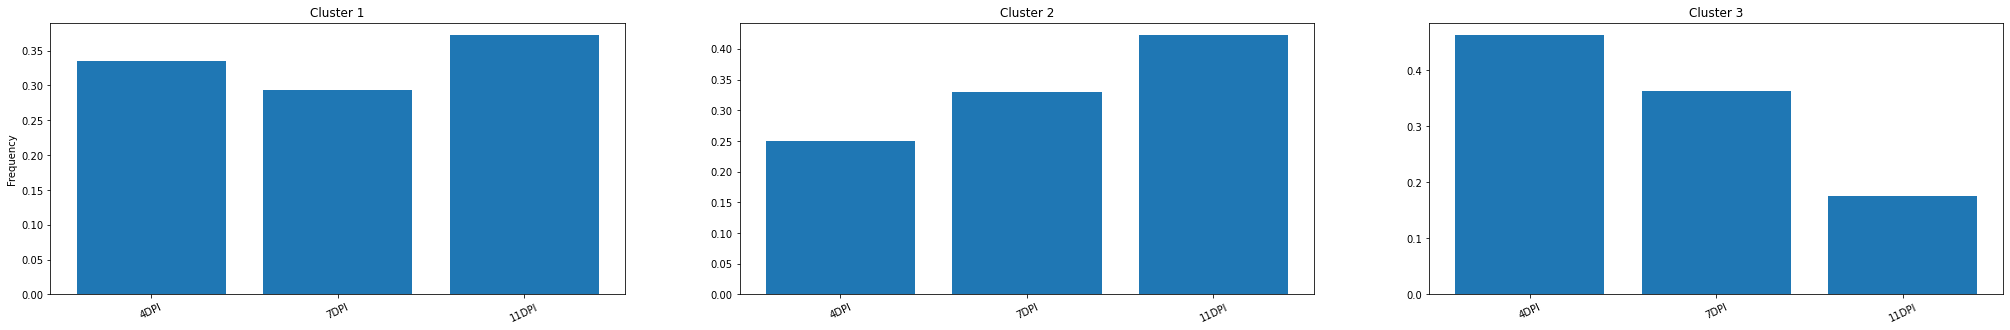

In [9]:
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(train_embeddings)
clusters_plko = kmeans.labels_
centroids_plko = kmeans.cluster_centers_

labels = ["4DPI", "7DPI", "11DPI"]
kmeans_frequencies_plko = {
    key: [0] * len(labels) for key in np.unique(clusters_plko)
}
with tarfile.open("/home-local/Frederic/Datasets/ALS/catalog/train_ALS.tar", "r") as handle:
    for cluster_id, member_name in tqdm(zip(clusters_plko, train_names), total=len(clusters_plko)):
        member = handle.getmember(name=member_name)
        buffer = io.BytesIO()
        buffer.write(handle.extractfile(member).read())
        buffer.seek(0)
        data = np.load(buffer, allow_pickle=True)
        data = {key: values for key, values in data.items()}
        metadata = data["metadata"].item()
        if metadata["DIV"] == "DIV14":
            continue
        key = metadata["DPI"]
        kmeans_frequencies_plko[cluster_id][labels.index(key)] += 1


total_images = 0
for key, value in kmeans_frequencies_plko.items():
    total_images += sum(value)  
    value = [item / sum(value) for item in value]
    print(key, value)

print(f"Total images: {total_images}")

fig, axs = plt.subplots(1, len(np.unique(clusters_plko)), figsize=(35, 5))
for i in range(len(np.unique(clusters_plko))):
    total = sum(kmeans_frequencies_plko[i])
    axs[i].bar(labels, [item / total for item in kmeans_frequencies_plko[i]])
    axs[i].set_title(f"Cluster {i+1}")
    axs[i].set_xticklabels(labels, rotation=25)
    axs[0].set_ylabel("Frequency")
plt.show()

### shFUS

(13022,)


  0%|          | 0/13022 [00:00<?, ?it/s]

100%|██████████| 13022/13022 [00:12<00:00, 1014.42it/s]
<ipython-input-10-5c0429d46394>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels, rotation=25)


0 [0.33412415974693555, 0.3044681692368525, 0.36140767101621196]
1 [0.2776336274001038, 0.32174364296834457, 0.40062272963155166]
2 [0.46551724137931033, 0.358128078817734, 0.17635467980295566]
Total images: 6486


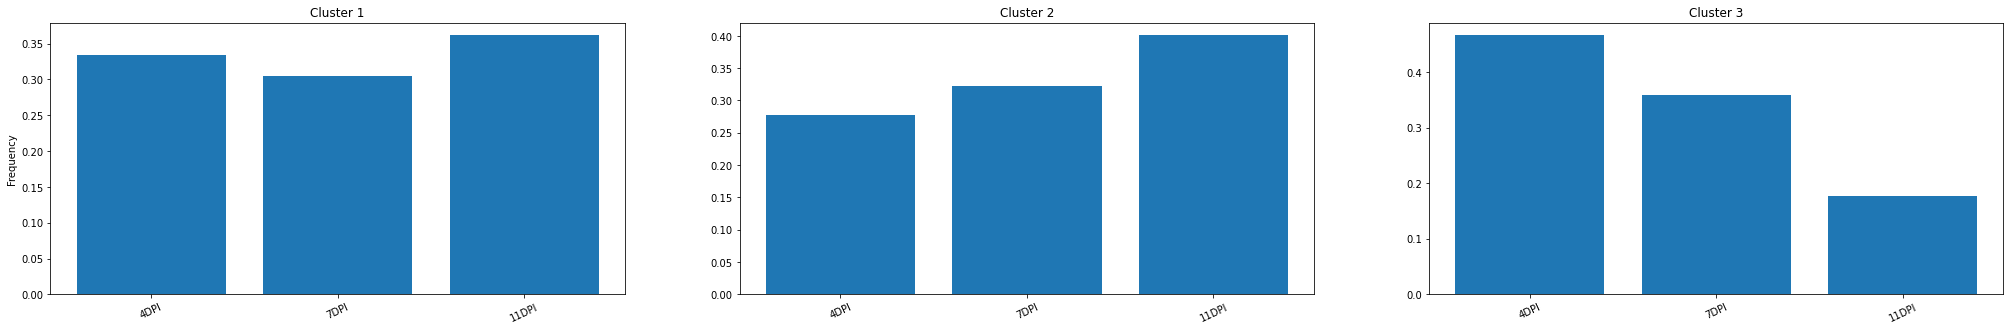

In [10]:
from scipy.spatial.distance import cdist

distances = cdist(test_embeddings, centroids_plko)
clusters_shfus = np.argmin(distances, axis=1)
print(clusters_shfus.shape)

kmeans_frequencies_shfus = {
    key: [0] * len(labels) for key in np.unique(clusters_shfus)
}
with tarfile.open("/home-local/Frederic/Datasets/ALS/catalog/test_ALS.tar", "r") as handle:
    for cluster_id, member_name in tqdm(zip(clusters_shfus, test_names), total=len(clusters_shfus)):
        member = handle.getmember(name=member_name)
        buffer = io.BytesIO()
        buffer.write(handle.extractfile(member).read())
        buffer.seek(0)
        data = np.load(buffer, allow_pickle=True)
        data = {key: values for key, values in data.items()}
        metadata = data["metadata"].item()
        if metadata["DIV"] == "DIV14":
            continue
        key = metadata["DPI"]
        kmeans_frequencies_shfus[cluster_id][labels.index(key)] += 1
        

total_images = 0
for key, value in kmeans_frequencies_shfus.items():
    total_images += sum(value)
    value = [item / sum(value) for item in value]
    print(key, value)

print(f"Total images: {total_images}")

fig, axs = plt.subplots(1, len(np.unique(clusters_shfus)), figsize=(35, 5))
for i in range(len(np.unique(clusters_shfus))):
    total = sum(kmeans_frequencies_shfus[i])
    axs[i].bar(labels, [item / total for item in kmeans_frequencies_shfus[i]])
    axs[i].set_title(f"Cluster {i+1}")
    axs[i].set_xticklabels(labels, rotation=25)
    axs[0].set_ylabel("Frequency")
plt.show()